# Getting Started

In [180]:
# Naming conventions (to be modified)
# 1. Use short variable names but not too short. So that any variable name can
# be uniquely found using Ctrl+F
# 2. Use underscore to concatenate words/numbers in one variable name

# Next steps
# 1. Write user inputs to *.inp file in Section [User inputs] (like e4d.inp)
# 2. Load *.inp and set global variables in Section [Global variables]
# 3. Modify lines to read in mesh in a safer way
# 4. When implementing 3rd kind B.C., the number of edges can be reduced by
# with_stern = (with_stern)&((np.abs(g_s)>0)|(np.abs(q_s)>0))

#4/5/2022 (fighting!)
# 5. Just added variables radius_b, e_0, f_0, s_0. Use them in the code
# 6. Consider is it possible to make c/alpha/beta/gamma 4 by 4 (Maybe yes!)

## System of equations

Assembling the system of equations for 2D triangle elements
This will take a while
Sparsity pattern for Ke and be (zoom-out vs zoom-in)


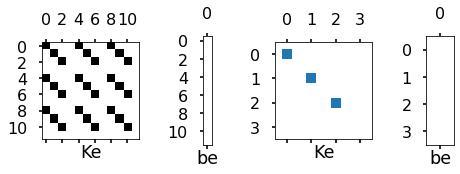

Time elapsed  18.782530307769775 sec

Assembling the system of equations for 1D line segments
Sparsity pattern for Ke and be (zoom-out vs zoom-in)


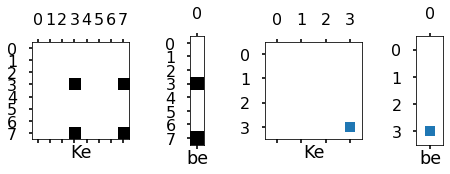

Time elapsed  3.3045578002929688 sec

Incoorprating the boundary condition of the third kind
Sparsity pattern for Ks and bs (zoom-out vs zoom-in)


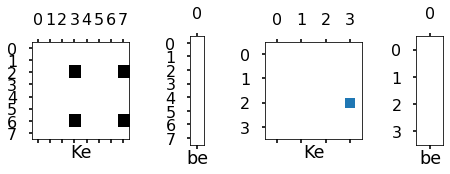

Time elapsed  2.8101768493652344 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  1.4561455249786377 sec

Calling sparse linear system solver
Time elapsed  0.5969452857971191 sec

Done


In [334]:
def update_materials(mesh,pot_0):
    n_elem = len(mesh['elements'])
    in_water = mesh['in_water']
    elem_factor = mesh['elem_factor']
    
    n_ion = len(c_ion)
    cinf = c_ion[0] #ion concentration
    ze = q_ion[0] #ion valence times elementary charge
    u2d_scale = ze*pot_0[:]/K_B/temperature #scaled potential in elements
    a = 2*ze**2*N_A*cinf/K_B/temperature*np.cosh(u2d_scale)
    f = -2*ze*N_A*cinf*(np.sinh(u2d_scale)-np.cosh(u2d_scale)*u2d_scale)
    
    materials = {}
    materials['a'] = np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    materials['f'] = np.zeros((n_elem,n_ion+2),dtype=float)
    
    for i in range(n_ion):
        materials['a'][:,i,i] = 1.0*elem_factor
    materials['a'][in_water,n_ion,n_ion] = a[in_water]*elem_factor[in_water]*1.0
    materials['f'][in_water,n_ion] = f[in_water]*elem_factor[in_water]*1.0    
    return materials

def build_system(mesh,domain,stern,robin,dirichlet):
    n_node = len(mesh['nodes'])
    n_rep = len(c_ion)*mode+2
    K1 = csr_matrix((n_node*n_rep,n_node*n_rep),dtype=float)
    K2 = csr_matrix((n_node*n_rep,n_node*n_rep),dtype=float)
    b1 = np.zeros(n_node*n_rep,dtype=float)
    b2 = np.zeros(n_node*n_rep,dtype=float)
    
    K1,K2,b1,b2 = assemble_Ke_2d(mesh,domain,K1,K2,b1,b2)
    K1,K2,b1,b2 = assemble_Ke_1d(mesh,stern,K1,K2,b1,b2)
    K1,K2,b1,b2 = assemble_Ks_2d(mesh,robin,K1,K2,b1,b2)
    K,b = set_1st_kind_bc(mesh,dirichlet,K1+K2,b1+b2)
    return K,b

def solve_system(K,b):
    print('Calling sparse linear system solver')
    start = time.time()
    K.eliminate_zeros()
    sol = spsolve(K,b)
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return sol

if __name__ == '__main__':
    mode = 0
    n_elem = len(mesh['elements'])
    n_node = len(mesh['nodes'])

    ratio_p = 0.8
    sigma_stern = -ratio_p*sigma_solid
    sigma_diffuse = -(1-ratio_p)*sigma_solid
    
    sigma_stern = -0.1
    sigma_diffuse = -0.1
    
    #mesh = set_mesh(mesh_prefix,mode)
    domain = set_domain(mesh,mode)
    stern = set_stern(mesh,mode)
    robin = set_robin(mesh,mode)
    dirichlet = set_dirichlet(mesh,mode)
    
    if mode == 0:
        n_rep = len(c_ion)+2
        pot_0 = np.zeros(n_elem,dtype=float)
        materials = update_materials(mesh,pot_0)
        domain['a'][:] = materials['a']
        domain['f'][:] = materials['f']
        
#         #test purpose below
#         edges = mesh['edges']
#         mask = mesh['with_stern']
#         ind_n = np.unique(edges[mask,:].flatten(order='C'))
        
#         robin['q_s'][:] = 0.0
#         robin['g_s'][mask,0] = -0.1*mesh['edge_factor'][mask]*dist_factor
#         robin['g_s'][~mask,0] = 0.0
#         dirichlet['on_1st_kind_bc'][ind_n,0] = True
#         dirichlet['s_n'][ind_n,0] = -0.1
    else:
        n_rep = len(c_ion)+2
    
    #K,b = build_system(mesh,domain,stern,robin,dirichlet)
    K1 = csr_matrix((n_node*n_rep,n_node*n_rep),dtype=float)
    K2 = csr_matrix((n_node*n_rep,n_node*n_rep),dtype=float)
    b1 = np.zeros(n_node*n_rep,dtype=float)
    b2 = np.zeros(n_node*n_rep,dtype=float)
    
    K1,K2,b1,b2 = assemble_Ke_2d(mesh,domain,K1,K2,b1,b2)
    K1,K2,b1,b2 = assemble_Ke_1d(mesh,stern,K1,K2,b1,b2)
    K1,K2,b1,b2 = assemble_Ks_2d(mesh,robin,K1,K2,b1,b2)
    K,b = set_1st_kind_bc(mesh,dirichlet,K1+K2,b1+b2)
    
    sol = solve_system(K,b)
    print('Done')

## Display results

In [ ]:
def ansol_sphere(x,y,z,radius_a,rel_perm_a,temperature,c_ion,z_ion,zeta,grad_flag):
    print('Computing 1D linear PB solution in spherical coordinates')
    perm_a = perm_0*rel_perm_a
    q_ion = z_ion*q_e
    Db_len = np.sqrt(perm_a*K_B*temperature/2/q_ion**2/N_A/c_ion)
    
    print('SOLID PARTICLE RADIUS IS:',radius_a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_a)
    print('TEMPERATURE IS:',temperature)
    print('ION COCENTRATION AT INFINITY IS:',c_ion)
    print('ION VALENCE IS:',z_ion)
    print('THERMAL ENERGY IS:',K_B*temperature/q_ion)
    
    if grad_flag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    
    print('DEBYE LENGTH IS:',Db_len*1e9,'nm')
    print('')

    if grad_flag:
        zeta = zeta/(1/Db_len+1/radius_a)/perm_a

    dist = np.sqrt(x**2+y**2+z**2)
    phi = np.zeros((len(dist),4))
    mask = dist>= radius_a
    phi[mask,0] = zeta*radius_a*np.exp((radius_a-dist[mask])/Db_len)/dist[mask]
    phi[~mask,0] = zeta
    phi[mask,1] = -phi[mask,0]*(1/Db_len+1/dist[mask])*x[mask]/dist[mask]
    phi[mask,2] = -phi[mask,0]*(1/Db_len+1/dist[mask])*y[mask]/dist[mask]
    phi[mask,3] = -phi[mask,0]*(1/Db_len+1/dist[mask])*z[mask]/dist[mask]
    
    return phi

if __name__ == '__main__':
    n_node = len(mesh['nodes'])
    nodes = mesh['nodes']
    u_n = np.reshape(sol,(n_node,n_rep))
    
    fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=80)
    axes = ax.flatten()
#     x = np.linspace(0,10e-9,100)
#     y = np.zeros_like(x)
#     z = np.zeros_like(x)
#     ansol = ansol_sphere(x=x,y=y,z=z,
#         radius_a=5e-9,rel_perm_a=78.5,temperature=298.0,
#         c_ion=100.0,z_ion=1.0,zeta=0.01,grad_flag=True)
#     axes[0].plot(x,ansol[:,0],'.')
#     print(ansol[0,0])

    x = nodes[:,0]/dist_factor
    y = nodes[:,1]/dist_factor
    z = np.zeros(n_node,dtype=float)
    ansol = ansol_sphere(x=x,y=y,z=z,
        radius_a=radius_a,rel_perm_a=80.0,temperature=293.0,
        c_ion=1.0,z_ion=1.0,zeta=-0.1,grad_flag=True)
    dist = np.sqrt(nodes[:,0]**2+nodes[:,1]**2)/dist_factor
    mask = (dist>=1.0*radius_a)&(dist<=1.015*radius_a)
    mask = (dist>=0.9*radius_a)&(dist<=1.2*radius_a)
    print(max(dist),radius_a)
    axes[0].plot(dist[mask],ansol[mask,0],'.')
    axes[0].plot(dist[mask],u_n[mask,-2],'.',markersize=5)
    
    edges = mesh['edges']
    mask = mesh['with_stern']
    ind_n = np.unique(edges[mask,:].flatten(order='C'))
    axes[1].plot(u_n[ind_n,-1],'.')
    axes[1].set_ylim([-1,0])
    print(u_n[ind_n,-1])
    
    axes[0].set_xlabel('Distance (m)')
    axes[1].set_xlabel('Distance (m)')
    axes[0].set_title('$U^{(0)}_a$')
    axes[1].set_title('$U^{(0)}_a$')
    
    plt.tight_layout()
    plt.show()


# Main subroutines

## Reset notebook

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
plt.style.use('seaborn-poster')

import copy,os,subprocess,time
import numpy as np
import numpy.matlib
from scipy import constants
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#set physicsical constants
q_e = constants.value(u'elementary charge') #1.602e-19 [C]
perm_0 = constants.value(u'vacuum electric permittivity') #8.85e-12 [F/m]
N_A = constants.value(u'Avogadro constant') #6.022e23 [1/mol]
K_B = constants.value(u'Boltzmann constant') #1.381e-23 [J/K]
K_F = constants.value(u'Faraday constant') #96485.0 [C/mol]

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

if __name__ == '__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## Global variables

In [178]:
# This section will load user inputs and set global variables
# Not implemented yet
# Go to user inputs for desired test case as a temporary solution

# Placeholder
# Need to consider which variables are user inputs

# E4D files
# 1. file .inp
# 2. file .sig
# 3. file .cfg
# 4. file .inv (skip for sip)
# 5. file .out
# 6. file .srv

# Possible SIP files
# 1. file .inp (specifies run_mode: 1 for mesh generation; 2 for static solution; 3 for coupled solution)
# 2. file .hdf5 (stores mesh and material properties for domain equation and boundary equation)
# 3. file .cfg (will generate .poly for triangle; will be compatible with sphere/slab/membrane models)
# 4. file .out (specifies output options)
# 5. file .srv (specifies survey/external field options)

import pprint

print('='*80)
%whos str
print('='*80)
%whos int
print('='*80)
%whos float
print('='*80)
%whos list
print('='*80)
%whos dict
print('='*80)
print('dirichlet',end=': ')
pprint.pprint(dirichlet.keys())
print('domain',end=': ')
pprint.pprint(domain.keys())
print('mesh',end=': ')
pprint.pprint(mesh.keys())
print('robin',end=': ')
pprint.pprint(robin.keys())
print('stern',end=': ')
pprint.pprint(stern.keys())

Variable      Type    Data/Info
-------------------------------
mesh_prefix   str     sphere_coupled
triangle      str     triangle
Variable                       Type    Data/Info
------------------------------------------------
EDGE_FLAG_AW_INTERFACE         int     2
EDGE_FLAG_AXIS_SYMMETRY        int     4
EDGE_FLAG_BOTTOM_BOUND         int     12
EDGE_FLAG_EQUIPOTENTIAL_SURF   int     3
EDGE_FLAG_LEFT_BOUND           int     13
EDGE_FLAG_RIGHT_BOUND          int     14
EDGE_FLAG_SW_INTERFACE         int     1
EDGE_FLAG_TOP_BOUND            int     11
ELEM_FLAG_AIR                  int     3
ELEM_FLAG_SOLID                int     1
ELEM_FLAG_WATER                int     2
mode                           int     0
n_elem                         int     75838
n_node                         int     38012
n_rep                          int     2
Variable        Type     Data/Info
----------------------------------
Diff_s          float    1.2624393229042688e-10
K_B             float    

## Basic functions

In [333]:
def shape_fun_2d(nodes,elements):
    #compute shape function Je for 2D triangular elements
    #input: nodes.shape (n_node,2)
    #input: elements.shape (n_nelem,3)
    #output: Je.shape(n_elem,3,3)
    #output: area.shape (n_elem,)
    
    print('Computing shape function for 2D triangular elements')
    print('This will take a minute')
    start = time.time()
    
    n_elem = len(elements)
    Je = np.zeros((n_elem,3,3),dtype=float)
    area = np.zeros(n_elem,dtype=float)
    
    x_node = nodes[elements,0] #(n_elem,3)
    y_node = nodes[elements,1] #(n_elem,3)
    
    for i in range(n_elem):
        A = np.ones((3,3),dtype=float)
        A[1,:] = x_node[i,:]
        A[2,:] = y_node[i,:]
        Je[i,:,:] = np.linalg.inv(A)
        area[i] = np.linalg.det(A)/2.0
    
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return Je,area

def shape_fun_1d(nodes,edges):
    #compute shape function Je for 1D line segments
    #input: nodes.shape (n_node,2)
    #input: edges.shape (n_edge,2)
    #output: Je.shape(n_edge,2,2)
    #output: length.shape (n_edge,)
    
    print('Computing shape function for 2D line segments')
    print('This will take a minute')
    start = time.time()
    
    n_edge = len(edges)
    Je = np.zeros((n_edge,2,2),dtype=float)
    length = np.zeros(n_edge,dtype=float)
    
    x_node = nodes[edges,0] #(n_edge,2)
    y_node = nodes[edges,1] #(n_edge,2)
    
    for i in range(n_edge):
        #first compute rotation matrix R
        A = np.zeros((3,3),dtype=float)
        R = np.zeros((3,3),dtype=float)
        
        n = np.r_[x_node[i,1]-x_node[i,0],y_node[i,1]-y_node[i,0],0.0]
        norm_n = np.linalg.norm(n)
        n = n/norm_n
        x = np.r_[1.0,0.0,0.0]
        k = np.cross(n,x)
        norm_k = np.linalg.norm(k)
        if norm_k>1e-8: #consider improving threshold
            k = k/norm_k

            cos_b = np.dot(n,x)
            sin_b = np.sqrt(1-cos_b**2)

            A[0,:] = [0,-k[2],k[1]]
            A[1,:] = [k[2],0,-k[0]]
            A[2,:] = [-k[1],k[0],0]
            R = np.eye(3)+A.dot(sin_b)+A.dot(A.dot(1-cos_b))
        else:
            R = np.eye(3)

        #next compute Je and length
        B = np.ones((2,2),dtype=float)
        x_loc = np.zeros(2,dtype=float)
        x_loc[0] = R[0,0]*x_node[i,0]+R[0,1]*y_node[i,0]
        x_loc[1] = R[0,0]*x_node[i,1]+R[0,1]*y_node[i,1]
        B[1,:] = x_loc
        Je[i,:,:] = np.linalg.inv(B)
        length[i] = np.abs(x_loc[1]-x_loc[0])
    
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return Je,length

def rotate_lines(nodes,edges):
    #rotate 2D line along vector n to x
    #input: nodes.shape (n_node,2)
    #input: edges.shape (n_edge,2)
    #output: R.shape (n_edge,2,2)
    
    print('Computing rotation matrix for 2D line segments')
    print('This will take a minute')
    start = time.time()
    
    n_edge = len(edges)
    M = np.zeros((n_edge,2,2),dtype=float)
    
    x_node = nodes[edges,0] #(n_edge,2)
    y_node = nodes[edges,1] #(n_edge,2)
    
    for i in range(n_edge):
        A = np.zeros((3,3),dtype=float)
        R = np.zeros((3,3),dtype=float)
        
        n = np.r_[x_node[i,1]-x_node[i,0],y_node[i,1]-y_node[i,0],0.0]
        norm_n = np.linalg.norm(n)
        n = n/norm_n
        x = np.r_[1.0,0.0,0.0]
        k = np.cross(n,x)
        norm_k = np.linalg.norm(k)
        if norm_k>1e-8: #consider improving threshold
            k = k/norm_k

            cos_b = np.dot(n,x)
            sin_b = np.sqrt(1-cos_b**2)

            A[0,:] = [0,-k[2],k[1]]
            A[1,:] = [k[2],0,-k[0]]
            A[2,:] = [-k[1],k[0],0]
            R = np.eye(3)+A.dot(sin_b)+A.dot(A.dot(1-cos_b))
        else:
            R = np.eye(3)
        
        M[i,:,:] = R[:-1,:-1]
    
    #let
    # [x_old,y_old]^T be 2 x 1 vector
    # [x_new,y_new]^T be 2 x 1 vector
    # R[:-1,:-1] be 2 x 2 matrix
    #then
    # [x_new,y_new]^T = R[:-1,:-1].dot([x_old,y_old]^T)
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return M

def assemble_Ke_2d(mesh,materials,K1_in,K2_in,b1_in,b2_in):
    print('Assembling the system of equations for 2D triangle elements')
    print('This will take a while')
    start = time.time()
    n_node = len(mesh['nodes'])
    n_elem = len(mesh['elements'])
    n_rep = materials['c_x'].shape[1]
    
    nodes = mesh['nodes']
    elements = mesh['elements']
    Je = mesh['elem_shape_fun']
    area = mesh['elem_area']
    elem_proc = mesh['elem_proc']
    
    c_x = materials['c_x']
    c_y = materials['c_y']
    alpha_x = materials['alpha_x']
    alpha_y = materials['alpha_y']
    beta_x = materials['beta_x']
    beta_y = materials['beta_y']
    gamma_x = materials['gamma_x']
    gamma_y = materials['gamma_y']
    a = materials['a']
    f = materials['f']
    a_n = materials['a_n']
    f_n = materials['f_n']
    
    I = np.zeros(n_elem*9*n_rep**2,dtype=int)
    J = np.zeros(n_elem*9*n_rep**2,dtype=int)
    V1 = np.zeros(n_elem*9*n_rep**2,dtype=float)
    V2 = np.zeros(n_elem*9*n_rep**2,dtype=float)
    b1 = np.zeros(n_node*n_rep,dtype=float)
    b2 = np.zeros(n_node*n_rep,dtype=float)

    REP = np.reshape(np.arange(n_node*n_rep,dtype=int),(n_node,n_rep))
    ROW = np.matlib.repmat(np.arange(3*n_rep,dtype=int),3*n_rep,1).T
    COL = np.matlib.repmat(np.arange(3*n_rep,dtype=int),3*n_rep,1)
    
    pattern_k = np.any(np.sign(c_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(c_y).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(alpha_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(alpha_y).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(beta_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(beta_y).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(a).astype(bool),axis=0)    
    pattern_k = csr_matrix(pattern_k)
    
    pattern_b = np.any(np.sign(f).astype(bool),axis=0)
    pattern_b = pattern_b|np.any(np.sign(gamma_x).astype(bool),axis=0)
    pattern_b = pattern_b|np.any(np.sign(gamma_y).astype(bool),axis=0)
    pattern_b = np.reshape(pattern_b,(-1,1))
    pattern_b = csr_matrix(pattern_b)

    stack_k = [[None]*3 for i in range(3)]
    stack_b = [[None]*1 for i in range(3)]
    for i in range(3):
        for j in range(3):
            stack_k[i][j] = pattern_k
        stack_b[i][0] = pattern_b
    stack_k = bmat(stack_k).toarray()
    stack_b = bmat(stack_b).toarray()
    
    ind_k = np.where(stack_k.flatten(order='C'))[0]
    ind_b = np.where(stack_b.flatten(order='C'))[0]
    print('Sparsity pattern for Ke and be (zoom-out vs zoom-in)')
    fig,ax = plt.subplots(1,4,figsize=(8,2))
    axes = ax.flatten()
    axes[0].spy(stack_k)
    axes[1].spy(stack_b)
    axes[2].spy(pattern_k)
    axes[3].spy(pattern_b)
    axes[1].set_xticks(range(1))
    axes[3].set_xticks(range(1))
    axes[0].set_xlabel('Ke')
    axes[1].set_xlabel('be')
    axes[2].set_xlabel('Ke')
    axes[3].set_xlabel('be')
    plt.show()

    elem_proc = elem_proc&materials['inside']
    for i in range(n_elem):
        cnt = i*9*n_rep**2
        ind_n = elements[i,:]
        if elem_proc[i] == True:
            #Ke1,Ke2,be1 = build_Ke_2d(c_x=c_x[i,:,:],c_y=c_y[i,:,:],
            #    alpha_x=alpha_x[i,:,:],alpha_y=alpha_y[i,:,:],
            #    beta_x=beta_x[i,:,:],beta_y=beta_y[i,:,:],
            #    gamma_x=gamma_x[i,:],gamma_y=gamma_y[i,:],
            #    a=a[i,:,:],f=f[i,:],a_n=a_n[ind_n,:,:],f_n=f_n[ind_n,:],
            #    Je=Je[i,:,:],area=area[i])
            Ke1,Ke2,be1 = build_Ke2d(c_x=c_x[i,:,:],c_y=c_y[i,:,:],
                alpha_x=alpha_x[i,:,:],alpha_y=alpha_y[i,:,:],
                beta_x=beta_x[i,:,:],beta_y=beta_y[i,:,:],
                gamma_x=gamma_x[i,:],gamma_y=gamma_y[i,:],
                a=a[i,:,:],f=f[i,:],a_n=a_n[ind_n,:,:],f_n=f_n[ind_n,:],
                Je=Je[i,:,:],area=area[i],ind_k=ind_k,ind_b=ind_b)
        else:
            Ke1 = np.zeros((3*n_rep,3*n_rep),dtype=float)
            Ke2 = np.zeros((3*n_rep,3*n_rep),dtype=float)
            be1 = np.zeros(3*n_rep,dtype=float)
        
        nind_rep = REP[ind_n,:].flatten(order='C')
        I[cnt:cnt+9*n_rep**2] = nind_rep[ROW].flatten(order='C')
        J[cnt:cnt+9*n_rep**2] = nind_rep[COL].flatten(order='C')
        V1[cnt:cnt+9*n_rep**2] = Ke1.flatten(order='C')
        V2[cnt:cnt+9*n_rep**2] = Ke2.flatten(order='C')
        b1[nind_rep] = b1[nind_rep]+be1
        
    K1 = csr_matrix((V1,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K1_in
    K2 = csr_matrix((V2,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K2_in
    b1[:] = b1+b1_in
    b2[:] = b2_in
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K1,K2,b1,b2

def build_Ke_2d(c_x,c_y,alpha_x,alpha_y,beta_x,beta_y,gamma_x,gamma_y,a,f,
                a_n,f_n,Je,area):
    n_rep = len(c_x)
    Ke1 = np.zeros((3*n_rep,3*n_rep),dtype=float)
    Ke2 = np.zeros((3*n_rep,3*n_rep),dtype=float)
    be1 = np.zeros(3*n_rep,dtype=float)
    
    for i in range(3*n_rep):
        ii = int(i/n_rep) #ii^th node, i = 1,2,3
        kk = int(i)%n_rep #kk^th unknown, j = 1,2,3,4,...,n_rep
        for j in range(3*n_rep):
            jj = int(j/n_rep) #jk^th node, j = 1,2,3
            ll = int(j)%n_rep #ll^th unknown, l = 1,2,3,4,...,n_rep
            delta = 1-np.abs(np.sign(ii-jj))
            #Ke[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+c_y[kk,ll]*Je[ii,2]*Je[jj,2]+
            #           a[kk,ll]*(1+delta)/12.0+
            #           (alpha_x[kk,ll]*Je[ii,1]+alpha_y[kk,ll]*Je[ii,2])/3.0+
            #           (beta_x[kk,ll]*Je[jj,1]+beta_y[kk,ll]*Je[jj,2])/3.0+
            #           a_n[jj,kk,ll]*(1+delta)/12.0)*area
            Ke1[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+c_y[kk,ll]*Je[ii,2]*Je[jj,2]+
                        (alpha_x[kk,ll]*Je[ii,1]+alpha_y[kk,ll]*Je[ii,2])/3.0+
                        (beta_x[kk,ll]*Je[jj,1]+beta_y[kk,ll]*Je[jj,2])/3.0)*area
            Ke2[i,j] = (a[kk,ll]+a_n[jj,kk,ll])*area*(1+delta)/12.0
        
        be1[i] = (gamma_x[kk]*Je[ii,1]+gamma_y[kk]*Je[ii,2]+f[kk]/3.0)*area

        for jj in range(3):
            delta = 1-np.abs(np.sign(ii-jj))
            be1[i] = be1[i]+f_n[jj,kk]*area*(1+delta)/12.0

    return Ke1,Ke2,be1

def build_Ke2d(c_x,c_y,alpha_x,alpha_y,beta_x,beta_y,gamma_x,gamma_y,a,f,
               a_n,f_n,Je,area,ind_k,ind_b):
    n_rep = len(c_x)
    Ke1 = np.zeros((3*n_rep,3*n_rep),dtype=float)
    Ke2 = np.zeros((3*n_rep,3*n_rep),dtype=float)
    be1 = np.zeros(3*n_rep,dtype=float)
    
    for ij in ind_k:
        i = int(ij/(3*n_rep)) #for i in range(3*n_rep)
        ii = int(i/n_rep) #ii^th node, i = 1,2,3
        kk = int(i)%n_rep #kk^th unknown, j = 1,2,3,4,...,n_rep
        
        j = int(ij)%(3*n_rep) #for j in range(3*n_rep)
        jj = int(j/n_rep) #jj^th node, j = 1,2,3
        ll = int(j)%n_rep #ll^th unknown, l = 1,2,3,4,...,n_rep
        
        delta = 1-np.abs(np.sign(ii-jj))
        #Ke[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+c_y[kk,ll]*Je[ii,2]*Je[jj,2]+
        #           a[kk,ll]*(1+delta)/12.0+
        #           (alpha_x[kk,ll]*Je[ii,1]+alpha_y[kk,ll]*Je[ii,2])/3.0+
        #           (beta_x[kk,ll]*Je[jj,1]+beta_y[kk,ll]*Je[jj,2])/3.0+
        #           a_n[jj,kk,ll]*(1+delta)/12.0)*area
        Ke1[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+c_y[kk,ll]*Je[ii,2]*Je[jj,2]+
                    (alpha_x[kk,ll]*Je[ii,1]+alpha_y[kk,ll]*Je[ii,2])/3.0+
                    (beta_x[kk,ll]*Je[jj,1]+beta_y[kk,ll]*Je[jj,2])/3.0)*area
        Ke2[i,j] = (a[kk,ll]+a_n[jj,kk,ll])*area*(1+delta)/12.0
    
    for i in ind_b:
        ii = int(i/n_rep) #ii^th node, i = 1,2,3
        kk = int(i)%n_rep #kk^th unknown, j = 1,2,3,4,...,n_rep
        be1[i] = (gamma_x[kk]*Je[ii,1]+gamma_y[kk]*Je[ii,2]+f[kk]/3.0)*area
        
#         for jj in range(3):
#             delta = 1-np.abs(np.sign(ii-jj))
#             be1[i] = be1[i]+f_n[jj,kk]*area*(1+delta)/12.0

    return Ke1,Ke2,be1

def assemble_Ks_2d(mesh,materials,K1_in,K2_in,b1_in,b2_in):
    print('Incoorprating the boundary condition of the third kind')
    start = time.time()
    n_node = len(mesh['nodes'])
    n_edge = len(mesh['edges'])
    n_rep = materials['g_s'].shape[1]

    nodes = mesh['nodes']
    edges = mesh['edges']
    length = mesh['edge_len']
    edge_proc = mesh['edge_proc']

    g_s = materials['g_s']
    q_s = materials['q_s']
    

    I = np.zeros(n_edge*4*n_rep**2,dtype=int)
    J = np.zeros(n_edge*4*n_rep**2,dtype=int)
    V1 = np.zeros(n_edge*4*n_rep**2,dtype=float)
    V2 = np.zeros(n_edge*4*n_rep**2,dtype=float)
    b1 = np.zeros(n_node*n_rep,dtype=float)
    b2 = np.zeros(n_node*n_rep,dtype=float)
    
    REP = np.reshape(np.arange(n_node*n_rep,dtype=int),(n_node,n_rep))
    ROW = np.matlib.repmat(np.arange(2*n_rep,dtype=int),2*n_rep,1).T
    COL = np.matlib.repmat(np.arange(2*n_rep,dtype=int),2*n_rep,1)
    
    pattern_k = np.any(np.sign(q_s).astype(bool),axis=0)
    pattern_k = csr_matrix(pattern_k)
    
    pattern_b = np.any(np.sign(g_s).astype(bool),axis=0)
    pattern_b = np.reshape(pattern_b,(-1,1))
    pattern_b = csr_matrix(pattern_b)

    stack_k = [[None]*2 for i in range(2)]
    stack_b = [[None]*1 for i in range(2)]
    for i in range(2):
        for j in range(2):
            stack_k[i][j] = pattern_k
        stack_b[i][0] = pattern_b
    stack_k = bmat(stack_k).toarray()
    stack_b = bmat(stack_b).toarray()
    
    ind_k = np.where(stack_k.flatten(order='C'))[0]
    ind_b = np.where(stack_b.flatten(order='C'))[0]
    print('Sparsity pattern for Ks and bs (zoom-out vs zoom-in)')
    fig,ax = plt.subplots(1,4,figsize=(8,2))
    axes = ax.flatten()
    axes[0].spy(stack_k)
    axes[1].spy(stack_b)
    axes[2].spy(pattern_k)
    axes[3].spy(pattern_b)
    axes[1].set_xticks(range(1))
    axes[3].set_xticks(range(1))
    axes[0].set_xlabel('Ke')
    axes[1].set_xlabel('be')
    axes[2].set_xlabel('Ke')
    axes[3].set_xlabel('be')
    plt.show()

    edge_proc = edge_proc&materials['with_3rd_kind_bc']
    for i in range(n_edge):
        cnt = i*4*n_rep**2
        ind_n = edges[i,:]
        if edge_proc[i] == True:
            #Ks1,bs1 = build_Ks_2d(g_s=g_s[i,:],q_s=q_s[i,:,:],length=length[i])
            Ks1,bs1 = build_Ks2d(g_s=g_s[i,:],q_s=q_s[i,:,:],length=length[i],
                ind_k=ind_k,ind_b=ind_b)
        else:
            Ks1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
            bs1 = np.zeros(2*n_rep,dtype=float)
            
        nind_rep = REP[ind_n,:].flatten(order='C')
        I[cnt:cnt+4*n_rep**2] = nind_rep[ROW].flatten(order='C')
        J[cnt:cnt+4*n_rep**2] = nind_rep[COL].flatten(order='C')
        V1[cnt:cnt+4*n_rep**2] = Ks1.flatten(order='C')
        b1[nind_rep] = b1[nind_rep]+bs1

    K1 = csr_matrix((V1,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K1_in
    K2 = csr_matrix((V2,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K2_in
    b1[:] = b1+b1_in
    b2[:] = b2_in
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K1,K2,b1,b2

def build_Ks_2d(g_s,q_s,length):
    n_rep = len(g_s)
    Ks1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    bs1 = np.zeros(2*n_rep,dtype=float)
    
    for i in range(2*n_rep):
        ii = int(i/n_rep) #ii^th node, i=1,2
        kk = int(i)%n_rep #kkth unknown, j=1,2,3,4,...,n_rep
        for j in range(2*n_rep):
            jj = int(j/n_rep) #jj^th node, j=1,2
            ll = int(j)%n_rep #ll^th unknown, l=1,2,3,4,...,n_rep
            delta = 1-np.abs(np.sign(ii-jj))
            Ks1[i,j] = q_s[kk,ll]*length*(1+delta)/6.0
        
        bs1[i] = g_s[kk]*length/2.0
    
    return Ks1,bs1

def build_Ks2d(g_s,q_s,length,ind_k,ind_b):
    n_rep = len(g_s)
    Ks1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    bs1 = np.zeros(2*n_rep,dtype=float)
    
    for ij in ind_k:
        i = int(ij/(2*n_rep)) #for i in range(2*n_rep)
        ii = int(i/n_rep) #ii^th node, i=1,2
        kk = int(i)%n_rep #jj^th unknown, j=1,2,3,4,...,n_rep
        
        j = int(ij)%(2*n_rep) #for j in range(2*n_rep)
        jj = int(j/n_rep) #jj^th node, j=1,2
        ll = int(j)%n_rep #ll^th unknown, l=1,2,3,4,...,n_rep
        delta = 1-np.abs(np.sign(ii-jj))
        Ks1[i,j] = q_s[kk,ll]*length*(1+delta)/6.0
    
    for i in ind_b:
        ii = int(i/n_rep) #ii^th node, i=1,2
        kk = int(i)%n_rep #jj^th unknown, j=1,2,3,4,...,n_rep
        bs1[i] = g_s[kk]*length/2.0
        
    return Ks1,bs1

def assemble_Ke_1d(mesh,materials,K1_in,K2_in,b1_in,b2_in):
    print('Assembling the system of equations for 1D line segments')
    start = time.time()
    n_node = len(mesh['nodes'])
    n_edge = len(mesh['edges'])
    n_rep = materials['c_x'].shape[1]
    
    nodes = mesh['nodes']
    edges = mesh['edges']
    Je = mesh['edge_shape_fun']
    length = mesh['edge_len']
    edge_proc = mesh['edge_proc']
        
    c_x = materials['c_x']
    alpha_x = materials['alpha_x']
    beta_x = materials['beta_x']
    gamma_x = materials['gamma_x']
    a = materials['a']
    f = materials['f']

    I = np.zeros(n_edge*4*n_rep**2,dtype=int)
    J = np.zeros(n_edge*4*n_rep**2,dtype=int)
    V1 = np.zeros(n_edge*4*n_rep**2,dtype=float)
    V2 = np.zeros(n_edge*4*n_rep**2,dtype=float)
    b1 = np.zeros(n_node*n_rep,dtype=float)
    b2 = np.zeros(n_node*n_rep,dtype=float)
    
    REP = np.reshape(np.arange(n_node*n_rep,dtype=int),(n_node,n_rep))
    ROW = np.matlib.repmat(np.arange(2*n_rep,dtype=int),2*n_rep,1).T
    COL = np.matlib.repmat(np.arange(2*n_rep,dtype=int),2*n_rep,1)

    pattern_k = np.any(np.sign(c_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(alpha_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(beta_x).astype(bool),axis=0)
    pattern_k = pattern_k|np.any(np.sign(a).astype(bool),axis=0)
    pattern_k = csr_matrix(pattern_k)
    
    pattern_b = np.any(np.sign(f).astype(bool),axis=0)
    pattern_b = pattern_b|np.any(np.sign(gamma_x).astype(bool),axis=0)
    pattern_b = np.reshape(pattern_b,(-1,1))
    pattern_b = csr_matrix(pattern_b)
    
    stack_k = [[None]*2 for i in range(2)]
    stack_b = [[None]*1 for i in range(2)]
    for i in range(2):
        for j in range(2):
            stack_k[i][j] = pattern_k
        stack_b[i][0] = pattern_b
    stack_k = bmat(stack_k).toarray()
    stack_b = bmat(stack_b).toarray()
    
    ind_k = np.where(stack_k.flatten(order='C'))[0]
    ind_b = np.where(stack_b.flatten(order='C'))[0]
    print('Sparsity pattern for Ke and be (zoom-out vs zoom-in)')
    fig,ax = plt.subplots(1,4,figsize=(8,2))
    axes = ax.flatten()
    axes[0].spy(stack_k)
    axes[1].spy(stack_b)
    axes[2].spy(pattern_k)
    axes[3].spy(pattern_b)
    axes[1].set_xticks(range(1))
    axes[3].set_xticks(range(1))
    axes[0].set_xlabel('Ke')
    axes[1].set_xlabel('be')
    axes[2].set_xlabel('Ke')
    axes[3].set_xlabel('be')
    plt.show()
    
    edge_proc = edge_proc&materials['inside']
    for i in range(n_edge):
        cnt = i*4*n_rep**2
        ind_n = edges[i,:]
        if edge_proc[i] == True:
            #Ke1,Ke2,be1 = build_Ke_1d(c_x=c_x[i,:,:],alpha_x=alpha_x[i,:,:],beta_x=beta_x[i,:,:],
            #    gamma_x=gamma_x[i,:],a=a[i,:,:],f=f[i,:],Je=Je[i,:,:],length=length[i])
            Ke1,Ke2,be1 = build_Ke1d(c_x=c_x[i,:,:],alpha_x=alpha_x[i,:,:],beta_x=beta_x[i,:,:],
                gamma_x=gamma_x[i,:],a=a[i,:,:],f=f[i,:],Je=Je[i,:,:],length=length[i],
                ind_k=ind_k,ind_b=ind_b)
        else:
            Ke1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
            Ke2 = np.zeros((2*n_rep,2*n_rep),dtype=float)
            be1 = np.zeros(2*n_rep,dtype=float)
        
        nind_rep = REP[ind_n,:].flatten(order='C')
        I[cnt:cnt+4*n_rep**2] = nind_rep[ROW].flatten(order='C')
        J[cnt:cnt+4*n_rep**2] = nind_rep[COL].flatten(order='C')
        V1[cnt:cnt+4*n_rep**2] = Ke1.flatten(order='C')
        V2[cnt:cnt+4*n_rep**2] = Ke2.flatten(order='C')
        b1[nind_rep] = b1[nind_rep]+be1

    K1 = csr_matrix((V1,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K1_in
    K2 = csr_matrix((V2,(I,J)),shape=(n_node*n_rep,n_node*n_rep))+K2_in
    b1[:] = b1+b1_in
    b2[:] = b2_in
    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K1,K2,b1,b2

def build_Ke_1d(c_x,alpha_x,beta_x,gamma_x,a,f,Je,length):
    n_rep = len(c_x)
    Ke1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    Ke2 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    be1 = np.zeros(2*n_rep,dtype=float)
    
    for i in range(2*n_rep):
        ii = int(i/n_rep) #ii^th node, i=1,2,3
        kk = int(i)%n_rep #kk^th unknown, j=1,2,3,4,...,n_rep
        for j in range(2*n_rep):
            jj = int(j/n_rep) #jj^th node, j=1,2,3
            ll = int(j)%n_rep #ll^th unknown, l=1,2,3,4,...,n_rep
            delta = 1-np.abs(np.sign(ii-jj))
            #Ke[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+
            #          a[kk,ll]*(1+delta)/6.0+
            #          (alpha_x[kk,ll]*Je[ii,1])/2.0+
            #          (beta_x[kk,ll]*Je[jj,1])/2.0)*length
            Ke1[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+
                        (alpha_x[kk,ll]*Je[ii,1])/2.0+
                        (beta_x[kk,ll]*Je[jj,1])/2.0)*length
            Ke2[i,j] = a[kk,ll]*length*(1+delta)/6.0
            
        be1[i] = (gamma_x[kk]*Je[ii,1]+f[kk]/2.0)*length

    return Ke1,Ke2,be1

def build_Ke1d(c_x,alpha_x,beta_x,gamma_x,a,f,Je,length,ind_k,ind_b):
    n_rep = len(c_x)
    Ke1 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    Ke2 = np.zeros((2*n_rep,2*n_rep),dtype=float)
    be1 = np.zeros(2*n_rep,dtype=float)
    
    for ij in ind_k:
        i = int(ij/(2*n_rep)) #for i in range(2*n_rep)
        ii = int(i/n_rep) #ii^th node, i=1,2,3
        kk = int(i)%n_rep #kk^th unknown, j=1,2,3,4,...,n_rep
        
        j = int(ij)%(2*n_rep) #for j in range(2*n_rep)
        jj = int(j/n_rep) #jj^th node, j=1,2,3
        ll = int(j)%n_rep #ll^th unknown, l=1,2,3,4,...,n_rep
        delta = 1-np.abs(np.sign(ii-jj))
        #Ke[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+
        #          a[kk,ll]*(1+delta)/6.0+
        #          (alpha_x[kk,ll]*Je[ii,1])/2.0+
        #          (beta_x[kk,ll]*Je[jj,1])/2.0)*length
        Ke1[i,j] = (c_x[kk,ll]*Je[ii,1]*Je[jj,1]+
                    (alpha_x[kk,ll]*Je[ii,1])/2.0+
                    (beta_x[kk,ll]*Je[jj,1])/2.0)*length
        Ke2[i,j] = a[kk,ll]*length*(1+delta)/6.0
    
    for i in ind_b:
        ii = int(i/n_rep) #ii^th node, i=1,2,3
        kk = int(i)%n_rep #kk^th unknown, j=1,2,3,4,...,n_rep
        be1[i] = (gamma_x[kk]*Je[ii,1]+f[kk]/2.0)*length

    return Ke1,Ke2,be1

def set_1st_kind_bc(mesh,materials,K_in,b_in):
    print('Incoorprating the Dirichlet boundary condition')
    start = time.time()
    n_node = len(mesh['nodes'])
    n_rep = materials['s_n'].shape[1]
    
    nodes = mesh['nodes']
    edges = mesh['edges']
    
    on_1st_kind_bc = materials['on_1st_kind_bc'].flatten(order='C')
    s_n = materials['s_n'].flatten(order='C')
    
    K = csr_matrix.copy(K_in) #consider without copying
    b = np.array(b_in) #consider without copying
    
    b[~on_1st_kind_bc] = b[~on_1st_kind_bc]-K.dot(s_n)[~on_1st_kind_bc]
    b[on_1st_kind_bc] = s_n[on_1st_kind_bc]
    
    #reduce rows and cols by checking True or False in on_1st_kind_bc
    ind_n = np.where(on_1st_kind_bc)[0]
    rows = ind_n
    cols = ind_n
    M = csr_matrix(K.shape).tolil()
    M[rows,cols] = 1.0
    K = zero_rows(K,rows)
    K = zero_cols(K,cols)
    K = K+M

    elapsed = time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def zero_rows(M,rows):
    diag = sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r] = 0
    #diag[rows,rows] = 0
    return diag.dot(M)

def zero_cols(M,cols):
    diag = sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c] = 0
    #diag[cols,cols] = 0
    return M.dot(diag)

if __name__ == '__main__':
    print('Done')

Done


## Mesh properties

Reading sphere_coupled.1.node
Reading sphere_coupled.1.ele
Reading sphere_coupled.1.edge
THE NUMBER OF NODES IS: 38012
THE NUMBER OF ELEMENTS IS: 75838
THE NUMBER OF EDGES IS: 113849
node_flags [ 0  1  4 11 13 14]
elem_flags [1 2]
edge_flags [ 0  1  4 11 13 14]

Computing shape function for 2D triangular elements
This will take a minute
Time elapsed  1.4851875305175781 sec

Computing shape function for 2D line segments
This will take a minute
Time elapsed  19.82759404182434 sec

AXIS OF SYMMETRY: ALONG X

Done


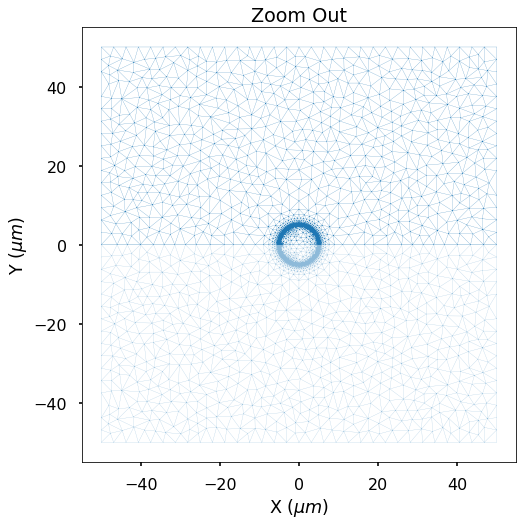

In [5]:
def set_mesh(mesh_prefix):
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes = np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2),dtype=float)
    node_flags = np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype=int)

    print('Reading %s.1.ele'%mesh_prefix)
    elements = np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype=int)
    elem_flags = np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype=int)

    print('Reading %s.1.edge'%mesh_prefix)
    edges = np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype=int)
    edge_flags = np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype=int)

    #adjust indices to start from zero
    elements = elements-1
    edges = edges-1
    
    #scale nodes from meter to micro-meter
    nodes = nodes*1e-6*dist_factor
    
    n_node = len(nodes)
    n_elem = len(elements)
    n_edge = len(edges)
    print('THE NUMBER OF NODES IS: %d'%n_node)
    print('THE NUMBER OF ELEMENTS IS: %d'%n_elem)
    print('THE NUMBER OF EDGES IS: %d'%n_edge)
    print('node_flags',np.unique(node_flags))
    print('elem_flags',np.unique(elem_flags))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #compute assisting variables
    elem_shape_fun,area = shape_fun_2d(nodes,elements)
    edge_shape_fun,length = shape_fun_1d(nodes,edges)
    
    elem_mids = np.zeros((n_elem,2))
    x_node = nodes[elements,0] #(n_elem,3)
    y_node = nodes[elements,1] #(n_elem,3)
    elem_mids[:,0] = np.sum(x_node,axis=1)/3.0
    elem_mids[:,1] = np.sum(y_node,axis=1)/3.0
    
    edge_mids = np.zeros((n_edge,2))
    x_node = nodes[edges,0] #(n_edge,2)
    y_node = nodes[edges,1] #(n_edge,2)
    edge_mids[:,0] = np.sum(x_node,axis=1)/2.0
    edge_mids[:,1] = np.sum(y_node,axis=1)/2.0
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #assign processor id
    elem_proc = np.ones(n_elem,dtype=bool)
    edge_proc = np.ones(n_edge,dtype=bool)
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #display mesh
    disp_factor = 1e6/dist_factor
    x = nodes[:,0]*disp_factor
    y = nodes[:,1]*disp_factor
    
    fig,ax = plt.subplots(figsize=(8,8))    
    ax.triplot(x,y,elements[:,:],linewidth=0.2,color='tab:blue')
    ax.triplot(x,-y,elements[:,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    ax.set_xlabel('X $(\mu m)$')
    ax.set_ylabel('Y $(\mu m)$')
    ax.set_aspect('equal')
    ax.set_title('Zoom Out')
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #output variables
    mesh = {}
    mesh['nodes'] = nodes.astype(float)
    mesh['elements'] = elements.astype(int)
    mesh['edges'] = edges.astype(int)
    
    mesh['node_flags'] = node_flags.astype(int)
    mesh['elem_flags'] = elem_flags.astype(int)
    mesh['edge_flags'] = edge_flags.astype(int)
    
    mesh['elem_shape_fun'] = elem_shape_fun.astype(float)
    mesh['elem_area'] = area.astype(float)
    mesh['elem_mids'] = elem_mids.astype(float)
    mesh['elem_proc'] = elem_proc.astype(bool)
    
    mesh['edge_shape_fun'] = edge_shape_fun.astype(float)
    mesh['edge_len'] = length.astype(float)
    mesh['edge_mids'] = edge_mids.astype(float)
    mesh['edge_proc'] = edge_proc.astype(bool)
    
    mesh['in_air'] = elem_flags==ELEM_FLAG_AIR
    mesh['in_water'] = elem_flags==ELEM_FLAG_WATER
    mesh['in_solid'] = elem_flags==ELEM_FLAG_SOLID
    
    mesh['with_stern'] = edge_flags==EDGE_FLAG_SW_INTERFACE
    mesh['with_equipotential'] = edge_flags==EDGE_FLAG_EQUIPOTENTIAL_SURF
    mesh['with_axis_symmetry'] = edge_flags==EDGE_FLAG_AXIS_SYMMETRY
    
    mesh['with_top_bound'] = edge_flags==EDGE_FLAG_TOP_BOUND
    mesh['with_bottom_bound'] = edge_flags==EDGE_FLAG_BOTTOM_BOUND
    mesh['with_left_bound'] = edge_flags==EDGE_FLAG_LEFT_BOUND
    mesh['with_right_bound'] = edge_flags==EDGE_FLAG_RIGHT_BOUND
    
    mesh['node_factor'] = np.zeros(n_node,dtype=float)
    mesh['elem_factor'] = np.zeros(n_elem,dtype=float)
    mesh['edge_factor'] = np.zeros(n_edge,dtype=float)
    
    with_axis_symmetry = mesh['with_axis_symmetry']
    x = nodes[edges[with_axis_symmetry,:],0].flatten(order='C')
    y = nodes[edges[with_axis_symmetry,:],1].flatten(order='C')
    if np.linalg.norm(x) == 0:
        print('AXIS OF SYMMETRY: ALONG Y')
        print('')
        mesh['node_factor'] = mesh['nodes'][:,0]
        mesh['elem_factor'] = mesh['elem_mids'][:,0]
        mesh['edge_factor'] = mesh['edge_mids'][:,0] #needs to be verified
    elif np.linalg.norm(y) == 0:
        print('AXIS OF SYMMETRY: ALONG X')
        print('')
        mesh['node_factor'] = mesh['nodes'][:,1]
        mesh['elem_factor'] = mesh['elem_mids'][:,1]
        mesh['edge_factor'] = mesh['edge_mids'][:,1] #needs to be verified
    else:
        print('AXIS OF SYMMETRY: NONE')
        print('')
        mesh['node_factor'] = 1.0
        mesh['elem_factor'] = 1.0
        mesh['edge_factor'] = np.ones(n_edge,dtype=float)

    return mesh

if __name__ == '__main__':
    mesh = set_mesh(mesh_prefix)
    print('Done')

## Material properties

In [326]:
ratio_p = 0.8
sigma_stern = -ratio_p*sigma_solid
sigma_diffuse = -(1-ratio_p)*sigma_solid

def set_domain(mesh,mode):
    freq = 1.0 #placeholder
    #n_ion = len(c_ion)*mode
    n_ion = len(c_ion)
    ind_c = np.arange(0,n_ion)
    ind_p = n_ion
    ind_s = n_ion+1
    
    n_dim = 2
    n_node = len(mesh['nodes'])
    n_elem = len(mesh['elements'])
    n_edge = len(mesh['edges'])
    
    #shortcut to values in mesh
    nodes = mesh['nodes']
    elements = mesh['elements']
    edges = mesh['edges']
    
    node_flags = mesh['node_flags']
    elem_flags = mesh['elem_flags']
    edge_flags = mesh['edge_flags']
    
    in_air = mesh['in_air']
    in_water = mesh['in_water']
    in_solid = mesh['in_solid']
    
    node_factor = mesh['node_factor']
    elem_factor = mesh['elem_factor']
    edge_factor = mesh['edge_factor']
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #initialize domain keys and values
    domain = {}
    domain['inside'] = (in_air|in_water)|in_solid
    domain['c_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['c_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['alpha_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['alpha_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['beta_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['beta_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['gamma_x']=np.zeros((n_elem,n_ion+2),dtype=float)
    domain['gamma_y']=np.zeros((n_elem,n_ion+2),dtype=float)
    domain['a']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=float)
    domain['f']=np.zeros((n_elem,n_ion+2),dtype=float)
    domain['a_n']=np.zeros((n_node,n_ion+2,n_ion+2),dtype=float) #test purpose
    domain['f_n']=np.zeros((n_node,n_ion+2),dtype=float) #test purpose
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set domain properties in the air (mode 0 and mode 1 are the same)
    for i in range(n_ion):
        domain['c_x'][in_air,i,i] = 0.0
    domain['c_x'][in_air,ind_p,ind_p] = perm_0
    domain['c_x'][in_air,ind_s,ind_s] = 0.0
    
    for i in range(n_ion):
        domain['c_y'][in_air,i,i] = 0.0
    domain['c_y'][in_air,ind_p,ind_p] = perm_0
    domain['c_y'][in_air,ind_s,ind_s] = 0.0
    
    for i in range(n_ion):
        domain['a'][in_air,i,i] = 1.0*freq
    domain['a'][in_air,ind_p,ind_p] = 0.0
    domain['a'][in_air,ind_s,ind_s] = 0.0
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set domain properties in the water
    if mode == 0:
        for i in range(n_ion):
            domain['c_x'][in_water,i,i] = 0.0
        domain['c_x'][in_water,ind_p,ind_p] = perm_a
        domain['c_x'][in_water,ind_s,ind_s] = 0.0

        for i in range(n_ion):
            domain['c_y'][in_water,i,i] = 0.0
        domain['c_y'][in_water,ind_p,ind_p] = perm_a
        domain['c_y'][in_water,ind_s,ind_s] = 0.0

        for i in range(n_ion):
            domain['a'][in_water,i,i] = 1.0*freq
        domain['a'][in_water,ind_p,ind_p] = 0.0
        domain['a'][in_water,ind_s,ind_s] = 0.0
    else:
        for i in range(n_ion):
            domain['c_x'][in_water,i,i] = Diff_a[i]
            domain['c_x'][in_water,i,ind_p] = mu_a[i]*z_ion[i]*conc_stat[in_water,i]
        domain['c_x'][in_water,ind_p,ind_p] = perm_a
        domain['c_x'][in_water,ind_s,ind_s] = 0.0

        for i in range(n_ion):
            domain['c_y'][in_water,i,i] = Diff_a[i]
            domain['c_y'][in_water,i,ind_p] = mu_a[i]*z_ion[i]*conc_stat[in_water,i]
        domain['c_y'][in_water,ind_p,ind_p] = perm_a
        domain['c_y'][in_water,ind_s,ind_s] = 0.0

        for i in range(n_ion):
            domain['alpha_x'][in_water,i,i] = mu_a[i]*z_ion[i]*pot_stat[in_water,1]

        for i in range(n_ion):
            domain['alpha_y'][in_water,i,i] = mu_a[i]*z_ion[i]*pot_stat[in_water,2]

        for i in range(n_ion):
            domain['a'][in_water,i,i] = 1.0*freq
            domain['a'][in_water,ind_p,i] = -z_ion[i]*K_F
        domain['a'][in_water,ind_p,ind_p] = 0.0
        domain['a'][in_water,ind_s,ind_s] = 0.0

    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set domain properties in the solid (mode 0 and mode 1 are the same)
    for i in range(n_ion):
        domain['c_x'][in_solid,i,i] = 0.0
    domain['c_x'][in_solid,ind_p,ind_p] = perm_i
    domain['c_x'][in_solid,ind_s,ind_s] = 0.0
    
    for i in range(n_ion):
        domain['c_y'][in_solid,i,i] = 0.0
    domain['c_y'][in_solid,ind_p,ind_p] = perm_i
    domain['c_y'][in_solid,ind_s,ind_s] = 0.0
    
    for i in range(n_ion):
        domain['a'][in_solid,i,i] = 1.0*freq
    domain['a'][in_solid,ind_p,ind_p] = 0.0
    domain['a'][in_solid,ind_s,ind_s] = 0.0
        
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set point source for electric field
    for i in range(len(f_0)):
        x = f_0[i][0]
        y = f_0[i][1]
        ind_n = np.argmin((nodes[:,0]-x)**2+(nodes[:,1]-y)**2)
        domain['f_n'][ind_n,ind_p] = f_0[i][2]
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #multiply domain properties by elem_factor
    for i in range(n_ion+2):
        for j in range(n_ion+2):
            domain['c_x'][:,i,j] = domain['c_x'][:,i,j]*elem_factor
            domain['c_y'][:,i,j] = domain['c_y'][:,i,j]*elem_factor
            domain['alpha_x'][:,i,j] = domain['alpha_x'][:,i,j]*elem_factor
            domain['alpha_y'][:,i,j] = domain['alpha_y'][:,i,j]*elem_factor
            domain['beta_x'][:,i,j] = domain['beta_x'][:,i,j]*elem_factor
            domain['beta_y'][:,i,j] = domain['beta_y'][:,i,j]*elem_factor
            domain['a'][:,i,j] = domain['a'][:,i,j]*elem_factor
            domain['a_n'][:,i,j] = domain['a_n'][:,i,j]*node_factor
        
        domain['gamma_x'][:,i] = domain['gamma_x'][:,i]*elem_factor
        domain['gamma_y'][:,i] = domain['gamma_y'][:,i]*elem_factor
        domain['f'][:,i] = domain['f'][:,i]*elem_factor
        domain['f_n'][:,i] = domain['f_n'][:,i]*node_factor
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #scale domain properties over distance
    domain['c_x'][:] = domain['c_x']*dist_factor**2
    domain['c_y'][:] = domain['c_y']*dist_factor**2
    domain['alpha_x'][:] = domain['alpha_x']*dist_factor
    domain['alpha_y'][:] = domain['alpha_y']*dist_factor
    domain['beta_x'][:] = domain['beta_x']*dist_factor
    domain['beta_y'][:] = domain['beta_y']*dist_factor
    domain['a'][:] = domain['a']*1.0
    domain['a_n'][:] = domain['a_n']*1.0

    domain['gamma_x'][:] = domain['gamma_x']*dist_factor
    domain['gamma_y'][:] = domain['gamma_y']*dist_factor
    domain['f'][:] = domain['f']*1.0
    domain['f_n'][:] = domain['f_n']*1.0
    
    return domain

def set_stern(mesh,mode):
    freq = 1.0 #placeholder
    #n_ion = len(c_ion)*mode
    n_ion = len(c_ion)
    ind_c = np.arange(0,n_ion)
    ind_p = n_ion
    ind_s = n_ion+1
    
    n_dim = 2
    n_node = len(mesh['nodes'])
    n_elem = len(mesh['elements'])
    n_edge = len(mesh['edges'])
    
    #shortcut to variables in mesh
    nodes = mesh['nodes']
    elements = mesh['elements']
    edges = mesh['edges']
    
    node_flags = mesh['node_flags']
    elem_flags = mesh['elem_flags']
    edge_flags = mesh['edge_flags']
        
    node_factor = mesh['node_factor']
    elem_factor = mesh['elem_factor']
    edge_factor = mesh['edge_factor']
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #initialize stern keys and values
    stern = {}
    stern['inside'] = np.zeros(n_edge,dtype=bool)
    stern['c_x'] = np.zeros((n_edge,n_ion+2,n_ion+2),dtype=float)
    stern['alpha_x'] = np.zeros((n_edge,n_ion+2,n_ion+2),dtype=float)
    stern['beta_x'] = np.zeros((n_edge,n_ion+2,n_ion+2),dtype=float)
    stern['gamma_x'] = np.zeros((n_edge,n_ion+2),dtype=float)
    stern['a'] = np.zeros((n_edge,n_ion+2,n_ion+2),dtype=float)
    stern['f'] = np.zeros((n_edge,n_ion+2),dtype=float)

    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set stern properties
    with_stern = mesh['with_stern']
    stern['inside'][:] = with_stern
    if mode == 0:
        for i in range(n_ion):
            stern['c_x'][with_stern,i,i] = 0.0
        stern['c_x'][with_stern,ind_p,ind_p] = 0.0
        stern['c_x'][with_stern,ind_s,ind_s] = 0.0

        for i in range(n_ion):
            stern['a'][with_stern,i,i] = 0.0
        stern['a'][with_stern,ind_p,ind_p] = 0.0
        stern['a'][with_stern,ind_s,ind_s] = 1.0*freq
        
        stern['f'][with_stern,ind_s] = sigma_diffuse
    else:
        for i in range(n_ion):
            stern['c_x'][with_stern,i,i] = 0.0
        stern['c_x'][with_stern,ind_p,ind_p] = 0.0
        stern['c_x'][with_stern,ind_s,ind_p] = mu_s*sigma_stern
        stern['c_x'][with_stern,ind_s,ind_s] = Diff_s

        for i in range(n_ion):
            stern['a'][with_stern,i,i] = 0.0
        stern['a'][with_stern,ind_p,ind_p] = 0.0
        stern['a'][with_stern,ind_s,ind_s] = 1.0*freq

    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #multiply stern properties by edge_factor
    for i in range(n_ion+2):
        for j in range(n_ion+2):
            stern['c_x'][:,i,j] = stern['c_x'][:,i,j]*edge_factor
            stern['alpha_x'][:,i,j] = stern['alpha_x'][:,i,j]*edge_factor
            stern['beta_x'][:,i,j] = stern['beta_x'][:,i,j]*edge_factor
            stern['a'][:,i,j] = stern['a'][:,i,j]*edge_factor
        
        stern['gamma_x'][:,i] = stern['gamma_x'][:,i]*edge_factor
        stern['f'][:,i] = stern['f'][:,i]*edge_factor
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #scale stern properties over distance
    stern['c_x'][:] = stern['c_x']*dist_factor**2
    stern['alpha_x'][:] = stern['alpha_x']*dist_factor
    stern['beta_x'][:] = stern['beta_x']*dist_factor
    stern['a'][:] = stern['a']*1.0

    stern['gamma_x'][:] = stern['gamma_x']*dist_factor
    stern['f'][:] = stern['f']*1.0
    
    return stern

def set_robin(mesh,mode):
    freq = 1.0 #placeholder
    #n_ion = len(c_ion)*mode
    n_ion = len(c_ion)
    ind_c = np.arange(0,n_ion)
    ind_p = n_ion
    ind_s = n_ion+1

    n_dim = 2
    n_node = len(mesh['nodes'])
    n_elem = len(mesh['elements'])
    n_edge = len(mesh['edges'])
    
    #shortcut to variables in mesh
    nodes = mesh['nodes']
    elements = mesh['elements']
    edges = mesh['edges']
    
    node_flags = mesh['node_flags']
    elem_flags = mesh['elem_flags']
    edge_flags = mesh['edge_flags']
    
    node_factor = mesh['node_factor']
    elem_factor = mesh['elem_factor']
    edge_factor = mesh['edge_factor']
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #initialize robin keys and values
    robin = {}
    robin['with_3rd_kind_bc'] = np.zeros(n_edge,dtype=bool)
    robin['g_s'] = np.zeros((n_edge,n_ion+2),dtype=float)
    robin['q_s'] = np.zeros((n_edge,n_ion+2,n_ion+2),dtype=float)

    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set robin properties
    with_3rd_kind_bc = mesh['with_stern']
    robin['with_3rd_kind_bc'][:] = with_3rd_kind_bc
    robin['g_s'][with_3rd_kind_bc,:] = 0.0
    robin['q_s'][with_3rd_kind_bc,ind_p,ind_s] = -1.0
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #multiply robin properties by edge_factor
    for i in range(n_ion+2):
        for j in range(n_ion+2):
            robin['q_s'][:,i,j] = robin['q_s'][:,i,j]*edge_factor
        
        robin['g_s'][:,i] = robin['g_s'][:,i]*edge_factor
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #scale robin properties over distance
    robin['q_s'][:] = robin['q_s']*dist_factor
    robin['g_s'][:] = robin['g_s']*dist_factor
    
    return robin

def set_dirichlet(mesh,mode):
    freq = 1.0 #placeholder
    #n_ion = len(c_ion)*mode
    n_ion = len(c_ion)
    ind_c = np.arange(0,n_ion)
    ind_p = n_ion
    ind_s = n_ion+1
    
    n_dim = 2
    n_node = len(mesh['nodes'])
    n_elem = len(mesh['elements'])
    n_edge = len(mesh['edges'])
    
    #shortcut to variables in mesh
    nodes = mesh['nodes']
    elements = mesh['elements']
    edges = mesh['edges']
    
    node_flags = mesh['node_flags']
    elem_flags = mesh['elem_flags']
    edge_flags = mesh['edge_flags']
    
    node_factor = mesh['node_factor']
    elem_factor = mesh['elem_factor']
    edge_factor = mesh['edge_factor']
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #initialize variables for the 1st kind b.c.
    dirichlet = {}
    dirichlet['on_1st_kind_bc'] = np.zeros((n_node,n_ion+2),dtype=bool)
    dirichlet['s_n'] = np.zeros((n_node,n_ion+2),dtype=float)
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #set material properties for the 1st kind b.c. at infinity
    with_outer_bound = mesh['with_top_bound']
    with_outer_bound = with_outer_bound|mesh['with_bottom_bound']
    with_outer_bound = with_outer_bound|mesh['with_left_bound']
    with_outer_bound = with_outer_bound|mesh['with_right_bound']
    ind_n = np.unique(edges[with_outer_bound,:].flatten(order='C'))
    for i in range(n_ion): #for i^th ion
        dirichlet['on_1st_kind_bc'][ind_n,i] = True
        dirichlet['s_n'][ind_n,i] = 0.0
    
    if mode == 0:
        dirichlet['on_1st_kind_bc'][ind_n,ind_p] = True #for potential
        dirichlet['s_n'][ind_n,ind_p] = 0.0
    else:
        dirichlet['on_1st_kind_bc'][ind_n,ind_p] = True #for potential
        dirichlet['s_n'][ind_n,ind_p] = -nodes[ind_n,0]*e_0[0]-nodes[ind_n,1]*e_0[1]
    
    #set material properties for the 1st kind b.c. on equipotential surface
    with_inner_bound = mesh['with_equipotential']
    ind_n = np.unique(edges[with_inner_bound,:].flatten(order='C'))
    dirichlet['on_1st_kind_bc'][ind_n,n_ion] = True
    dirichlet['s_n'][ind_n,ind_p] = s_0
    
    #deactivate unused nodes in the air, water, and solid
    on_idle_nodes = np.ones(n_node,dtype=bool)
    mask = (mesh['in_air']|mesh['in_water'])|mesh['in_solid']
    ind_n = np.unique(elements[mask,:].flatten(order='C'))
    on_idle_nodes[ind_n] = False
    dirichlet['on_1st_kind_bc'][on_idle_nodes,:-1] = True
    dirichlet['s_n'][on_idle_nodes,:-1] = 0.0
    
    #deactivate unused nodes in Stern layer
    on_idle_nodes = np.ones(n_node,dtype=bool)
    mask = mesh['with_stern']
    ind_n = np.unique(edges[mask,:].flatten(order='C'))
    on_idle_nodes[ind_n] = False
    dirichlet['on_1st_kind_bc'][on_idle_nodes,-1] = True
    dirichlet['s_n'][on_idle_nodes,-1] = 0.0
    
    return dirichlet

if __name__ == '__main__':
    domain = set_domain(mesh,mode=0)
    stern = set_stern(mesh,mode=0)
    robin = set_robin(mesh,mode=0)
    dirichlet = set_dirichlet(mesh,mode=0)
    print('Done')

Done


# Sphere mesh (thick DL)

## User inputs

In [2]:
#make sure the user inputs meet the following requirements
#1) all numbers are float
#2) c_ion, z_ion, and mu_a have the same length
#3) empty c_ion/z_ion/mu_a means no diffuse layer
#4) empty mu_s means no stern layer

#USER INPUT block
#*******************************************************************************
#-------------------------------------------------------------------------------
#===============================================================================
#mesh name prefix
mesh_prefix = 'sphere_coupled'

#triangle executable path
#triangle = '/home/zhuy359/projects/E4D/third_party/triangle/triangle'
triangle = 'triangle'

#physical properties
rel_perm_a = 80.0 #relative permittivity of electrolyte [SI]
rel_perm_i = 4.5 #relative permittivity of solid [SI]
sigma_solid = 0.01 #surface charge density for solid [C]
temperature = 293.0 #ambient temperature [K]

c_ion = [1.0,1.0] #ion concentration at infinity [mol/m^3]
z_ion = [1.0,1.0] #ion valence or charge number [SI]

mu_a = [5e-8,5e-8] #ion mobility in electrolyte [m^2/(Vs)]
mu_s = 5e-9 #ion mobility in solid [m^2/(Vs)]

#mesh properties
radius_a = 5e-6 #radius of the sphere particle
radius_b = 10*radius_a #radius of the bounding box

#external field source
e_0 = [10.0,0.0] #Ex/Ey at infinity
f_0 = [[0.0,30e-9,0.0]] #coord_x/coord_y/charge density 
s_0 = 0.0 #voltage on equipotential surface

#hard coded mesh indexing constants
ELEM_FLAG_SOLID = 1
ELEM_FLAG_WATER = 2
ELEM_FLAG_AIR = 3

EDGE_FLAG_SW_INTERFACE = 1
EDGE_FLAG_AW_INTERFACE = 2
EDGE_FLAG_EQUIPOTENTIAL_SURF = 3
EDGE_FLAG_AXIS_SYMMETRY = 4

EDGE_FLAG_TOP_BOUND = 11
EDGE_FLAG_BOTTOM_BOUND = 12
EDGE_FLAG_LEFT_BOUND = 13
EDGE_FLAG_RIGHT_BOUND = 14

#DO NOT modify below
#*******************************************************************************
#-------------------------------------------------------------------------------
#===============================================================================
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# plt.style.use('seaborn-poster')

# import copy,os,subprocess,time
# import numpy as np
# import numpy.matlib
# from scipy import constants
# from scipy import sparse
# from scipy.sparse import csr_matrix
# from scipy.sparse.linalg import spsolve

def debye_length():
    n_ion = len(c_ion)
    Db_len=[0.0]*n_ion
    for i in range(n_ion):
        Db_len[i] = np.sqrt(perm_a*K_B*temperature/2/q_ion[i]/q_ion[i]/Conc_ion[i])
        
    return Db_len

# #set physicsical constants
# q_e = constants.value(u'elementary charge') #1.602e-19 [C]
# perm_0 = constants.value(u'vacuum electric permittivity') #8.85e-12 [F/m]
# N_A = constants.value(u'Avogadro constant') #6.022e23 [1/mol]
# K_B = constants.value(u'Boltzmann constant') #1.381e-23 [J/K]
# K_F = constants.value(u'Faraday constant') #96485.0 [C/mol]

#derive variables from user inputs
perm_a = rel_perm_a*perm_0
perm_i = rel_perm_i*perm_0
Diff_a = [val*K_B*temperature/q_e for val in mu_a]
Diff_s = mu_s*K_B*temperature/q_e

q_ion = [val*q_e for val in z_ion]
Conc_ion = [val*N_A for val in c_ion]
Db_len = debye_length()
dist_factor = 1e6

print('Done')

Done


## Radial discretization

DEBYE LENGTH IS: 9.63e+00 nm
Done


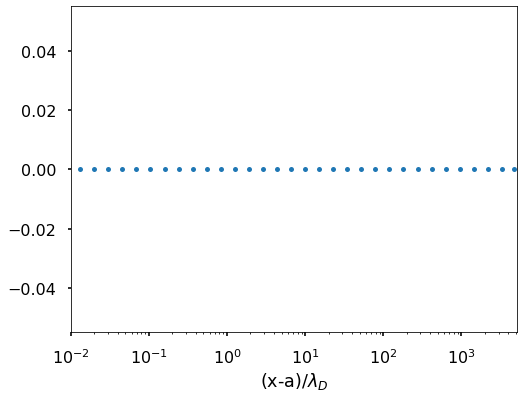

In [79]:
def discretize_rho():
    print('DEBYE LENGTH IS: %.2e nm'%(min(Db_len)*1e9))

    rho=np.logspace(np.log10(0.02),1,16)*min(Db_len)+radius_a
    #print(rho[0],rho[-1])
    dr=np.diff(np.log10((rho-radius_a)/min(Db_len)))[0]
    rho=np.power(10,np.arange(np.log10(0.02)-dr,1+dr*14,dr))*min(Db_len)+radius_a
    #print(rho[1],rho[16])
    rho=np.r_[0,radius_a,rho,radius_b]
    #print('See radial discretization below')
    #print(rho)
    #print(np.pi*radius_a/400,rho[2]-radius_a)
    
    fig,ax=plt.subplots(figsize=(8,6))
    mask=rho>radius_a
    ax.plot((rho[mask]-radius_a)/min(Db_len),np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlim(0.01,radius_b/min(Db_len))
    ax.set_xlabel('(x-a)/$\lambda_D$')
    
    return rho.astype(float)

if __name__ == '__main__':
    rho=discretize_rho()
    print('Done')
    plt.show()

## Mesh generation

Opening sphere_coupled.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  14
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  1
Adding Steiner points to enforce quality.
Quality milliseconds:  66

Writing sphere_coupled.1.node.
Writing sphere_coupled.1.ele.
Writing sphere_coupled.1.poly.
Writing sphere_coupled.1.edge.
Writing sphere_coupled.1.neigh.

Output milliseconds:  139
Total running milliseconds:  230

Statistics:

  Input vertices: 7780
  Input segments: 469
  Input holes: 0

  Mesh vertices: 38012
  Mesh triangles: 75838
  Mesh edges: 113849
  Mesh exterior boundary edges: 184
  Mesh interior boundary edges: 5377
  Mesh subsegments (constrained edges): 5561

Done


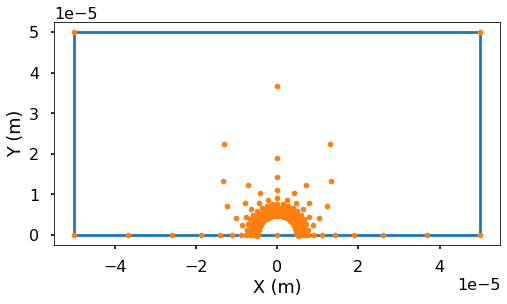

In [80]:
def generate_mesh():
    #X is the longitudinal axis
    #Y is the axis of symmetry
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    holes = np.zeros((0,2)) #coord_x/coord_y
    zones = np.zeros((0,3)) #coord_x/coord_y/area
    
    x = np.r_[0.0,0.0]
    y = np.r_[0.5*radius_a,2.0*radius_a]
    area = np.r_[1e12,(radius_b/20)**2]
    zones = np.r_[zones,np.c_[x,y,area]]
    
    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #define the two corner points on the topmost boundary
    x = np.r_[radius_b,-radius_b]
    y = np.r_[radius_b,radius_b]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the points on the axis of symmetry (Y = 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the inner sphere points centered at (0,0) with radius a
    dA = max(np.pi*radius_a/400,rho[2]-radius_a)/radius_a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = radius_a*np.cos(phi)+0.0
    y = radius_a*np.sin(phi)+0.0
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #define the inner refined points
    for i in range(3,len(rho)-1):
        dA = max(np.pi*radius_a/400,rho[i]-rho[i-1])/radius_a
        nA = np.ceil(np.pi/dA)
        ns = nA+1-2
        
        dA = np.pi/nA
        phi = np.arange(1,ns+1)*dA
        x = rho[i]*np.cos(phi)+0.0
        y = rho[i]*np.sin(phi)+0.0
        cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #define the segments on the topmost boundary (Y = 10*a)
    x = np.r_[radius_b,-radius_b]
    y = np.r_[radius_b,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,EDGE_FLAG_TOP_BOUND]] #predefined edge flag

    #define the segments on the axis of symmetry (Y = 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,EDGE_FLAG_AXIS_SYMMETRY]] #predefined edge flag
        
    #define the segments on the leftmost boundary (X = -10*a)
    x = np.r_[-radius_b,-radius_b]
    y = np.r_[0,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,EDGE_FLAG_LEFT_BOUND]] #edge flag of 6

    #define the segmesnts on the rightmost boundary (X = 10*a)
    x = np.r_[radius_b,radius_b]
    y = np.r_[0,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,EDGE_FLAG_RIGHT_BOUND]] #predefined edge flag
    
    #define the segments along the inner sphere centered at (0,0) with radius a
    dA = max(np.pi*radius_a/400,rho[2]-radius_a)/radius_a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(0,ns+2)*dA #half the circle
    x = radius_a*np.cos(phi)+0.0
    y = radius_a*np.sin(phi)+0.0
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,EDGE_FLAG_SW_INTERFACE]] #predefined edge flag
    
    
    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #build the poly file
    f1 = open(mesh_prefix+'.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers\n')
    
    #write the vertices
    cnt = 1
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e6,cpts[i,1]*1e6,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n')
    
    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1
    f1.write('\n')
    
    #write holes
    #f1.write('\n\n0\n\n')
    f1.write('%d\n'%(len(holes)))
    for i in range(len(holes)):
        x = holes[i,0]*1e6
        y = holes[i,1]*1e6
        f1.write('{0:6.0F} {1:12.6F} {2:12.6F} 1\n'.format(i+1,x,y))
    f1.write('\n')
    
    #write area constraints for zones
    #f1.write('2\n')
    #f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,0.5e6*a,1e12))
    #f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,2e6*a,(10e6*a/20)**2))
    f1.write('%d\n'%(len(zones)))
    for i in range(len(zones)):
        x = zones[i,0]*1e6
        y = zones[i,1]*1e6
        area = zones[i,2]*1e12
        f1.write('{0:6.0F} {1:12.6F} {2:12.6F} {3:6.0F} {4:12.6F}\n'.format(i+1,x,y,i+1,area))

    f1.write('\n')
    f1.write('# triangle -pnq30Aae '+mesh_prefix+'.poly \n')
    f1.close()
    
    fig,ax=plt.subplots(figsize=(8,6))
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    ax.plot(x.T,y.T,'-',color='tab:blue')
    ax.plot(cpts[:,0],cpts[:,1],'.',color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    return cpts.astype(float),segs.astype(int)

if __name__ == '__main__':
    cpts,segs=generate_mesh()
    process=subprocess.Popen([triangle+' -pnq30Aae '+mesh_prefix+'.poly'],shell=True)
    process.wait()
    print('Done')
    plt.show()